In [1]:
import os, json
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
from monai.networks.nets import SwinUNETR

# =========================
# 경로/환경 설정
# =========================

root_dir  = "C:/Users/admin/Documents/AIM_LAB/BraTS2025/BraTS-MEN-Train"
json_path = "C:/Users/admin/Documents/AIM_LAB/test_data.json"

# 학습 코드에서 저장한 모델 가중치 경로
ckpt_et    = "C:/Users/admin/Documents/AIM_LAB/output_et_1/swinunetr_et.pt"
ckpt_tc    = "C:/Users/admin/Documents/AIM_LAB/output_tc_1/swinunetr_tc.pt"
ckpt_flair = "C:/Users/admin/Documents/AIM_LAB/output_flair_1/swinunetr_flair.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# =========================
# 유틸(학습 코드 전처리와 동일)
# =========================
TARGET_SIZE = (128, 128, 128)

def normalize_minmax(arr: np.ndarray, eps: float = 1e-8):
    a_min, a_max = arr.min(), arr.max()
    return (arr - a_min) / (a_max - a_min + eps)

def resize_3d_numpy_to_torch(arr: np.ndarray, is_label: bool) -> np.ndarray:
    """학습 코드와 동일: [D,H,W] -> [1,1,D,H,W] -> interpolate -> [D,H,W]"""
    t = torch.from_numpy(arr).unsqueeze(0).unsqueeze(0).float()
    if is_label:
        t = F.interpolate(t, size=TARGET_SIZE, mode="nearest")
    else:
        t = F.interpolate(t, size=TARGET_SIZE, mode="trilinear", align_corners=False)
    return t.squeeze().cpu().numpy()

In [ ]:
# =========================
# 모델 로더 (학습 설정과 동일)
# =========================
def build_swinunetr(in_channels=4):
    net = SwinUNETR(
        img_size=TARGET_SIZE,
        in_channels=in_channels,
        out_channels=1,
        feature_size=48,
        use_checkpoint=True,
    )
    return net

def load_model(ckpt_path: str, in_channels=4):
    net = build_swinunetr(in_channels=in_channels).to(device)
    state = torch.load(ckpt_path, map_location=device)
    net.load_state_dict(state)
    net.eval()
    return net

In [ ]:
# =========================
# Fusion & Metric
# =========================
def fuse_probs_3class(
    p_et, p_tc, p_f,
    tie_win_size=3,
    eps_tie=1e-6,
    background_threshold=None,
    label_ids={"bg": 0, "tc": 1, "flair": 2, "et": 3}
):
    def _ensure_5d(x):
        if x.dim() == 3: return x.unsqueeze(0).unsqueeze(0)
        if x.dim() == 4: return x.unsqueeze(1)
        return x

    p_et = _ensure_5d(p_et).clamp(0, 1)
    p_tc = _ensure_5d(p_tc).clamp(0, 1)
    p_f  = _ensure_5d(p_f ).clamp(0, 1)

    probs = torch.cat([p_tc, p_f, p_et], dim=1)
    max_vals, top_idx = probs.max(dim=1)

    bg_mask = max_vals < background_threshold if background_threshold is not None else torch.zeros_like(max_vals, dtype=torch.bool)

    sorted_vals, sorted_idx = probs.sort(dim=1, descending=True)
    tie_mask = (sorted_vals[:, 0] - sorted_vals[:, 1]).abs() <= eps_tie

    k = tie_win_size; pad = k // 2
    kernel = torch.ones(1,1,k,k,k, device=probs.device)/(k**3)
    mean_tc = F.conv3d(p_tc, kernel, padding=pad)
    mean_f  = F.conv3d(p_f , kernel, padding=pad)
    mean_et = F.conv3d(p_et, kernel, padding=pad)
    local_means = torch.cat([mean_tc, mean_f, mean_et], dim=1)

    final_lbl = torch.zeros_like(top_idx, dtype=torch.long)
    final_lbl[top_idx==0]=label_ids["tc"]
    final_lbl[top_idx==1]=label_ids["flair"]
    final_lbl[top_idx==2]=label_ids["et"]

    if tie_mask.any():
        top2_idx=sorted_idx[:,:2]
        top2_means=torch.gather(local_means,1,top2_idx)
        choose_second=top2_means[:,1]>top2_means[:,0]
        def idx_to_id(idx_tensor):
            out=torch.empty_like(idx_tensor,dtype=torch.long)
            out[idx_tensor==0]=label_ids["tc"]
            out[idx_tensor==1]=label_ids["flair"]
            out[idx_tensor==2]=label_ids["et"]
            return out
        second_ids=idx_to_id(top2_idx[:,1])
        first_ids =idx_to_id(top2_idx[:,0])
        final_lbl=torch.where(tie_mask&choose_second,second_ids,final_lbl)
        final_lbl=torch.where(tie_mask&~choose_second,first_ids,final_lbl)

    final_lbl=torch.where(bg_mask, torch.tensor(label_ids["bg"], device=final_lbl.device), final_lbl)
    return final_lbl

In [6]:
def dice_per_class(pred, gt, n_class=4, eps=1e-7):
    dices = []
    for c in range(1, n_class):
        pred_c = (pred == c).astype(np.uint8)
        gt_c   = (gt == c).astype(np.uint8)
        if np.sum(gt_c) == 0 and np.sum(pred_c) == 0:
            dice = np.nan
        else:
            inter = np.sum(pred_c * gt_c)
            dice  = (2*inter + eps) / (np.sum(pred_c) + np.sum(gt_c) + eps)
        dices.append(dice)
    return dices

In [7]:
# =========================
# 모델 로드
# =========================
model_et    = load_model(ckpt_et,    in_channels=4)
model_tc    = load_model(ckpt_tc,    in_channels=4)
model_flair = load_model(ckpt_flair, in_channels=4)

In [ ]:
# =========================
# 데이터 로딩
# =========================
with open(json_path) as f:
    test_data = json.load(f)["test"]

results = []

for case in test_data:
    imgs = []
    for rel_path in case["image"]:
        nii = nib.load(os.path.join(root_dir, rel_path))
        arr = nii.get_fdata().astype(np.float32)
        arr = normalize_minmax(arr)
        arr = resize_3d_numpy_to_torch(arr, is_label=False)
        imgs.append(arr)
    imgs = np.stack(imgs, axis=0).astype(np.float32)          
    imgs_t = torch.from_numpy(imgs).unsqueeze(0).to(device)  

    gt_nii = nib.load(os.path.join(root_dir, case["label"]))
    gt_arr = gt_nii.get_fdata().astype(np.uint8)
    gt_arr_rs = resize_3d_numpy_to_torch(gt_arr, is_label=True).astype(np.uint8)

    with torch.no_grad():
        p_et    = torch.sigmoid(model_et(imgs_t))
        p_tc    = torch.sigmoid(model_tc(imgs_t))
        p_flair = torch.sigmoid(model_flair(imgs_t))

    labels = fuse_probs_3class(p_et, p_tc, p_flair, background_threshold=0.1)
    pred = labels.squeeze(0).cpu().numpy().astype(np.uint8)  

    dice_tc, dice_flair, dice_et = dice_per_class(pred, gt_arr_rs)
    dice_avg = np.nanmean([dice_tc, dice_flair, dice_et])

    case_name = case["label"].split("/")[0]
    results.append((case_name, dice_avg, dice_tc, dice_flair, dice_et, imgs, gt_arr_rs, pred))

print("총 케이스:", len(results))

총 케이스: 200


# BraTS 2021 Label

In [ ]:
print("threshold : 0.5")

def dice_cumulative(pred, gt, eps=1e-7):
    et_pred = (pred == 3).astype(np.uint8)
    tc_pred = np.isin(pred, [2, 3]).astype(np.uint8)
    wt_pred = np.isin(pred, [1, 2, 3]).astype(np.uint8)

    et_gt = (gt == 3).astype(np.uint8)
    tc_gt = np.isin(gt, [2, 3]).astype(np.uint8)
    wt_gt = np.isin(gt, [1, 2, 3]).astype(np.uint8)

    def _dice(p, g):
        if np.sum(g) == 0 and np.sum(p) == 0:
            return np.nan
        inter = np.sum(p * g)
        return (2 * inter + eps) / (np.sum(p) + np.sum(g) + eps)

    dice_et = _dice(et_pred, et_gt)
    dice_tc = _dice(tc_pred, tc_gt)
    dice_wt = _dice(wt_pred, wt_gt)
    dice_avg = np.nanmean([dice_et, dice_tc, dice_wt])
    return dice_et, dice_tc, dice_wt, dice_avg

# === Dice 계산 ===
results_new = []
for (case_name, _, _, _, _, imgs, gt_arr_rs, pred) in results:
    dice_et, dice_tc, dice_wt, dice_avg = dice_cumulative(pred, gt_arr_rs)
    results_new.append((case_name, dice_avg, dice_et, dice_tc, dice_wt))

# === 평균 Dice ===
def safe_mean(values):
    valid = [v for v in values if not math.isnan(v)]
    return sum(valid) / len(valid) if valid else float("nan")

mean_et = safe_mean([x[2] for x in results_new])
mean_tc = safe_mean([x[3] for x in results_new])
mean_wt = safe_mean([x[4] for x in results_new])
mean_all = safe_mean([x[1] for x in results_new])

print(f"Mean Dice - ET: {mean_et:.4f}, TC: {mean_tc:.4f}, WT: {mean_wt:.4f}")
print(f"Mean Dice (Overall Average): {mean_all:.4f}")

# === 정렬 (평균 Dice 기준) ===
results_sorted = sorted(results_new, key=lambda x: x[1], reverse=True)
n = len(results_sorted)
top5    = results_sorted[:5]
middle5 = results_sorted[n//2-2:n//2+3]
bottom5 = results_sorted[-5:]


threshold : 0.5
Mean Dice - ET: 0.8222, TC: 0.7709, WT: 0.7670
Mean Dice (Overall Average): 0.7867


# BraTS 2025 Task 2 Label

In [ ]:
import math

print("threshold : 0.5")

def safe_mean(values):
    valid = [v for v in values if not math.isnan(v)]
    return sum(valid) / len(valid) if valid else float("nan")

# === 클래스별 mean Dice 출력 ===
mean_tc    = safe_mean([x[2] for x in results])
mean_flair = safe_mean([x[3] for x in results])
mean_et    = safe_mean([x[4] for x in results])
mean_all   = safe_mean([x[1] for x in results])

print(f"Mean Dice - TC: {mean_tc:.4f}, FLAIR: {mean_flair:.4f}, ET: {mean_et:.4f}")
print(f"Mean Dice (Overall Average): {mean_all:.4f}")

# === 정렬 (예: 전체 평균 Dice 기준) ===
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
n = len(results_sorted)

top5    = results_sorted[:5]
middle5 = results_sorted[n//2-2:n//2+3]
bottom5 = results_sorted[-5:]


threshold : 0.5
Mean Dice - TC: 0.1105, FLAIR: 0.3923, ET: 0.8222
Mean Dice (Overall Average): 0.4588


In [ ]:
# 색상 맵 정의 (bg=검정, tc=빨강, flair=초록, et=파랑)
cmap = mcolors.ListedColormap([
    (0,0,0,1),  # bg
    (1,0,0,1),  # tc
    (0,1,0,1),  # flair
    (0,0,1,1),  # et
])
bounds=[0,1,2,3,4]
norm=mcolors.BoundaryNorm(bounds,cmap.N)

def show_group(cases, group_name):
    if len(cases) == 0:
        print(f"{group_name}: 케이스가 없습니다.")
        return
    n_cases = len(cases)
    fig, axes = plt.subplots(3, n_cases, figsize=(4*n_cases, 10))
    fig.suptitle(f"{group_name} Cases", fontsize=16)

    if n_cases == 1:
        axes = np.array([[axes[0]],[axes[1]],[axes[2]]]).squeeze(-1)

    for i, (case_name, dice_avg, dice_tc, dice_flair, dice_et, imgs, gt, pred) in enumerate(cases):
        label_sums = gt.sum(axis=(0,1))
        best_slice = int(np.argmax(label_sums))

        def fmt(x):
            return "N/A" if (x is None or np.isnan(x)) else f"{x:.3f}"

        axes[0,i].imshow(imgs[2,:,:,best_slice], cmap="gray")
        axes[0,i].set_title(
            f"{case_name}\nAvg={fmt(dice_avg)} | TC={fmt(dice_tc)}  FL={fmt(dice_flair)}  ET={fmt(dice_et)}",
            fontsize=9
        )
        axes[0,i].axis("off")

        axes[1,i].imshow(gt[:,:,best_slice], cmap=cmap, norm=norm)
        axes[1,i].set_title("Label")
        axes[1,i].axis("off")

        axes[2,i].imshow(pred[:,:,best_slice], cmap=cmap, norm=norm)
        axes[2,i].set_title("Prediction")
        axes[2,i].axis("off")

    plt.tight_layout()
    plt.show()

===== Top 5 =====


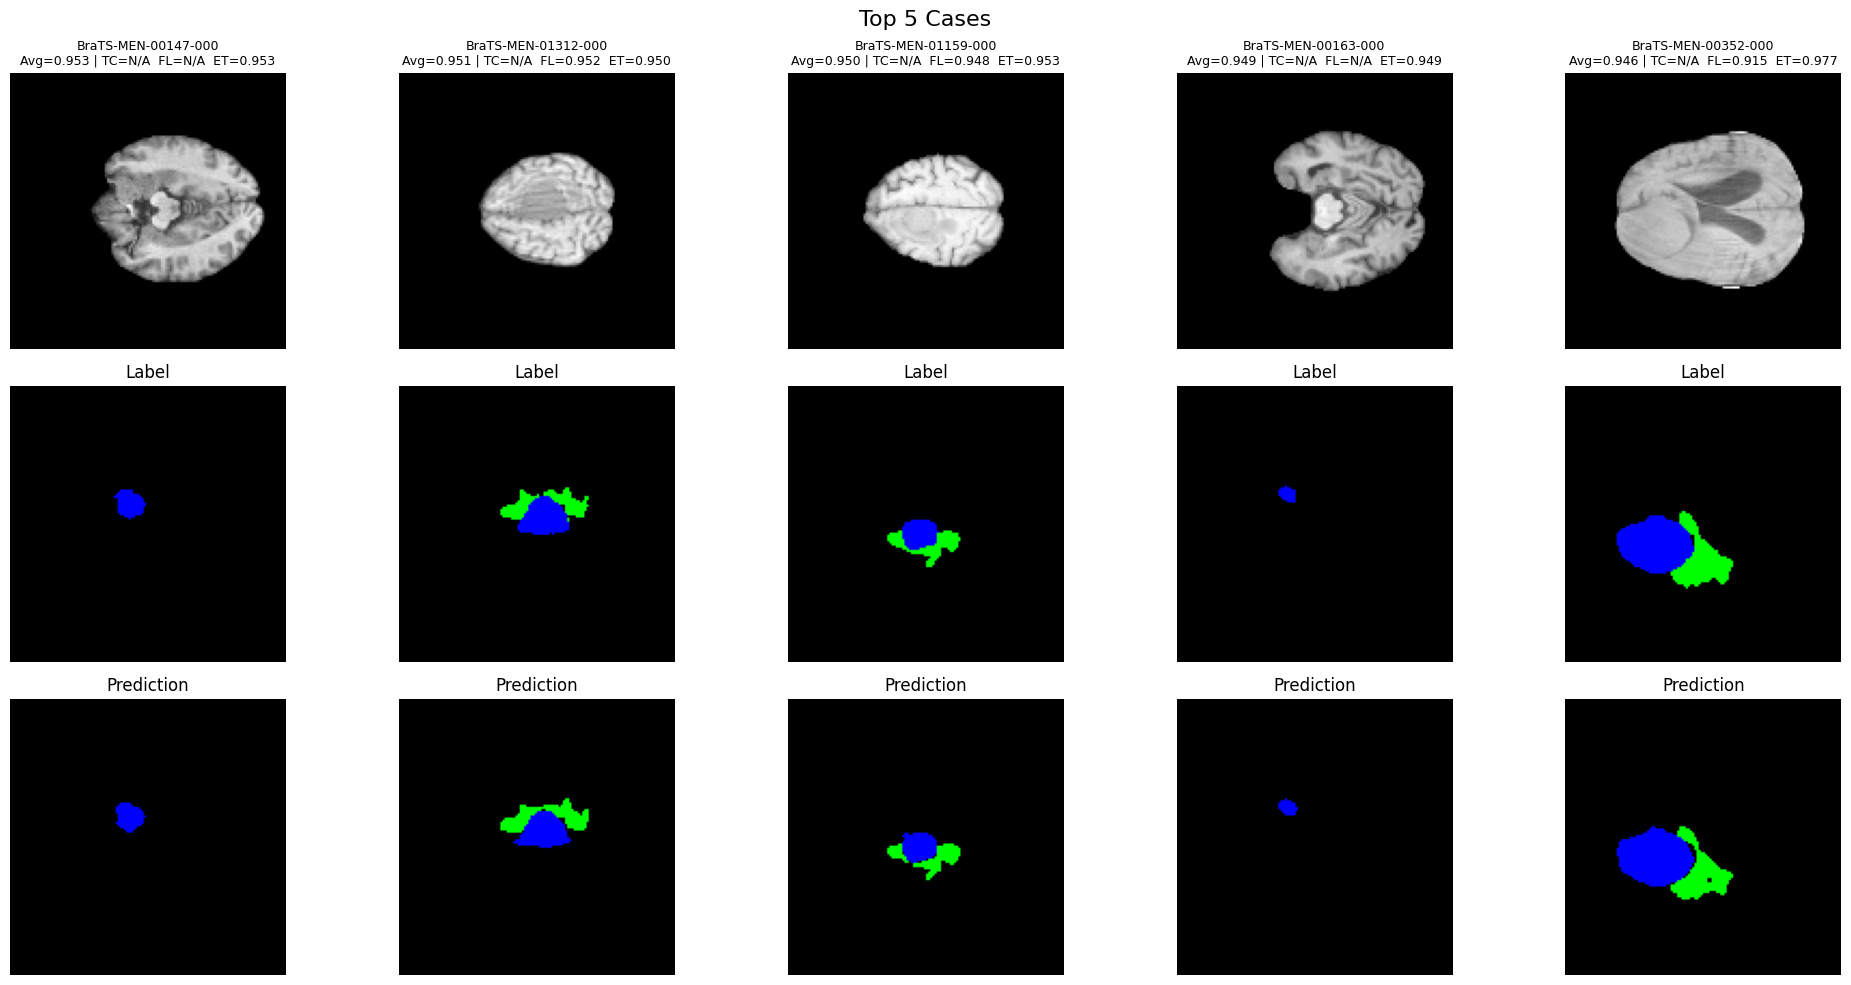

===== Middle 5 =====


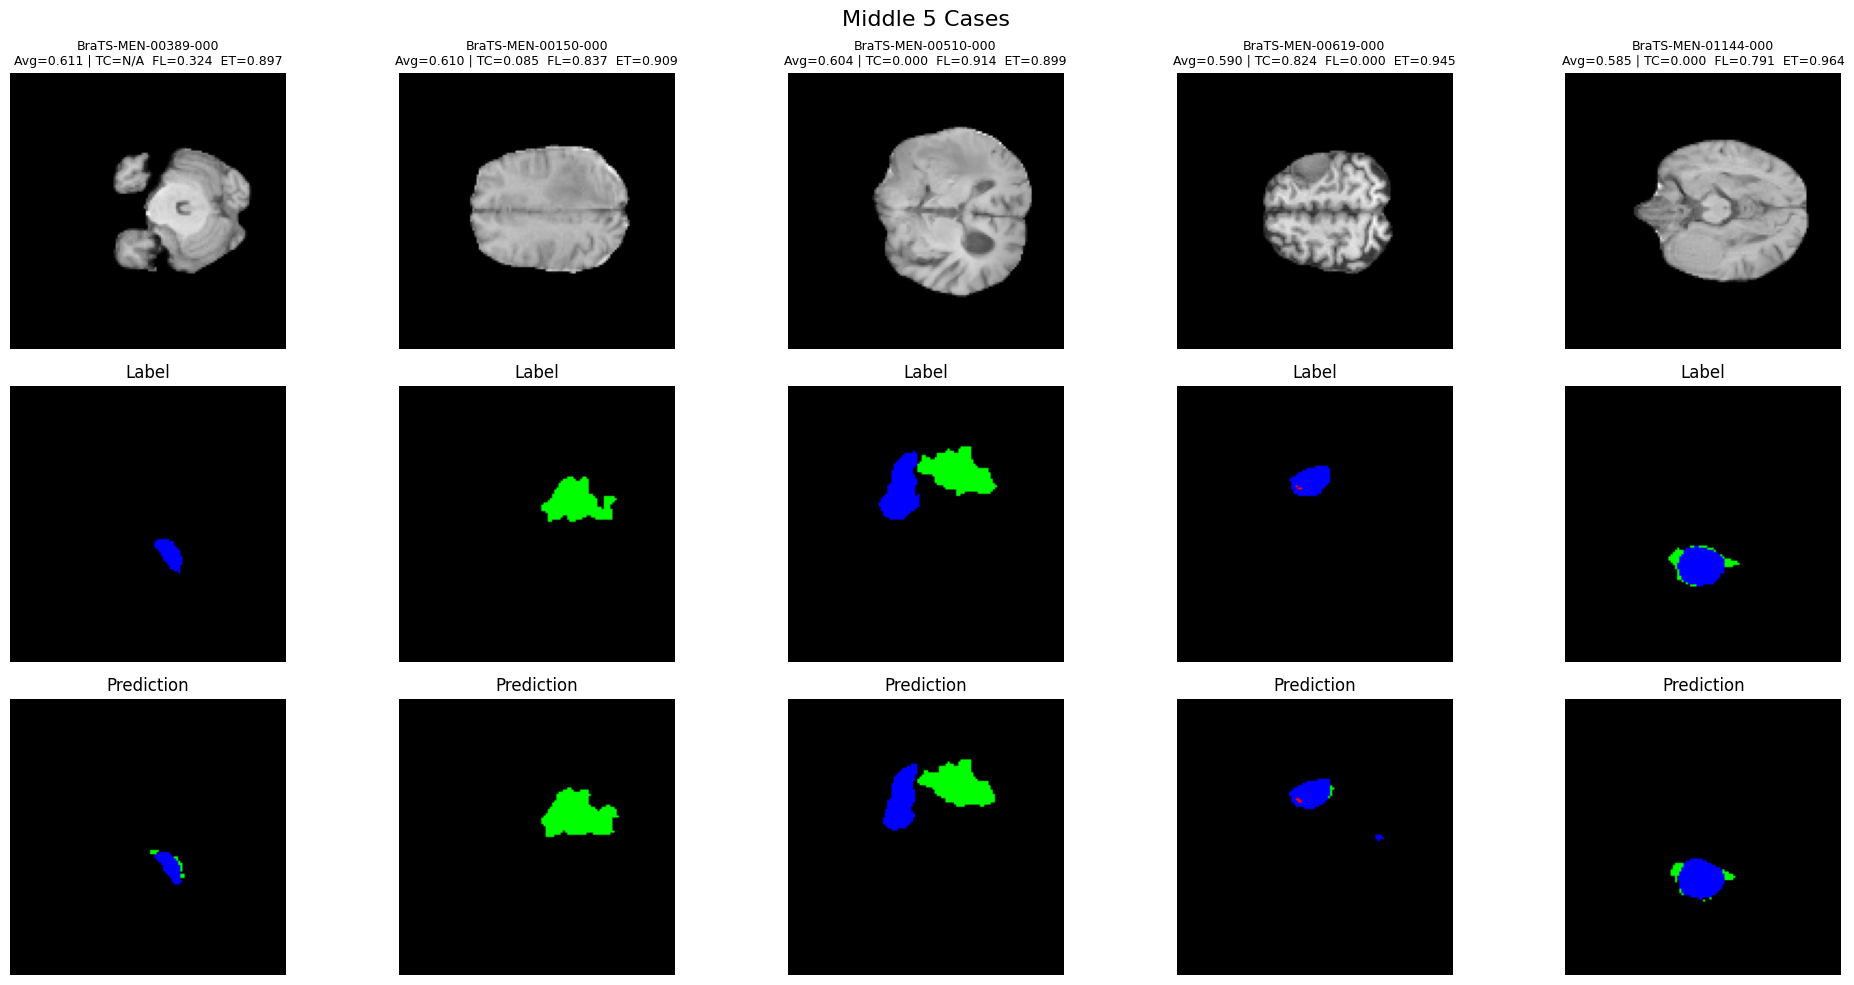

===== Bottom 5 =====


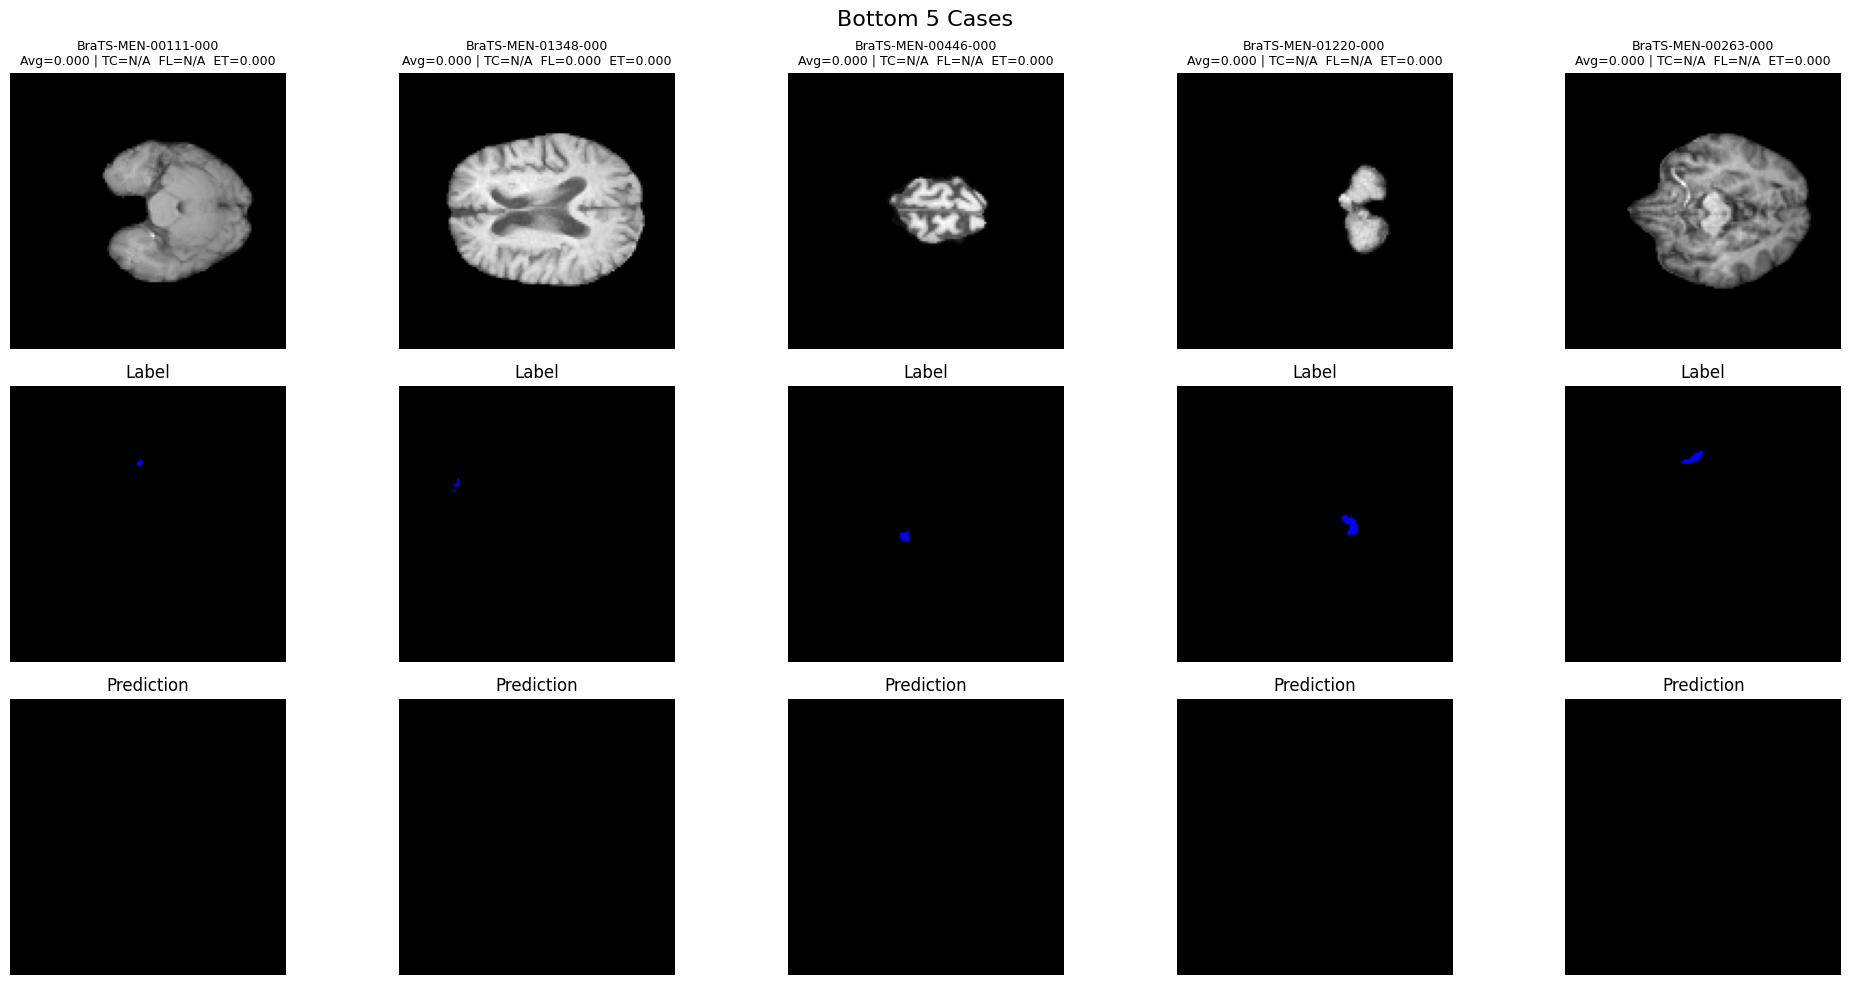

In [12]:
print("===== Top 5 =====")
show_group(top5, "Top 5")

print("===== Middle 5 =====")
show_group(middle5, "Middle 5")

print("===== Bottom 5 =====")
show_group(bottom5, "Bottom 5")